In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
import pickle

In [39]:
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [40]:
# %run SVR_MAPE_Library_new_weights.ipynb

In [41]:
%run SVR_MAPE_Library.ipynb

In [42]:
y1 =pd.read_excel(r'Data//Data1.xlsx').set_index("fecha").loc["2007-01-01":"2019-08-25"]
X1 = pd.read_csv("X.csv")

X = X1.drop(["fecha"], axis = 1).to_numpy(); y = y1.to_numpy()

# X, X_test, y, y_test = train_test_split(X, y, test_size = 100, shuffle = False)

# scaler = MaxAbsScaler(); scaler.fit(X); X = scaler.transform(X)
# X_test = scaler.transform(X_test)

# scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1.transform(y).reshape(-1)

# Continue

In [43]:
def bas_optit(C, epsilon, gamma, mu, lmbda): 
#   n: test size, itr: # of iterations
    n = 7; itr = 16
    
    cas = {}; mape = []; it = itr+1
    yl = len(y)
    
    # parameters
    hyperparameters = {
        'kernel' : "rbf",
        'C' : C, 
        'epsilon' : epsilon, 
        'mu' : mu,
        'lmbda' : lmbda,
        'gamma' : gamma, 
    }
    
    cas[0] = hyperparameters
    
    itera = np.flip(np.arange(1, it))
    for i in itera:
        j = i*n
        
        # y, X split
        X_train = X[:yl - j, :]; X_test = X[yl - j : yl - (j-n), :]
        y_train = y[:yl - j];    y_test = y[yl - j : yl - (j-n)]
        
        # test index
        y_idx = y1.index[yl - j : yl - (j-n)]
        
        # rescale X and y
        scaler = MaxAbsScaler(); scaler.fit(X_train); 
        X_train = scaler.transform(X_train); X_test = scaler.transform(X_test)
        
        scaler1 = MaxAbsScaler(); scaler1.fit(y_train)
        y_train = scaler1.transform(y_train).reshape(-1)
        y_test = y_test.reshape(-1)
        

        # fit and predict
        model = SVR_general_cvxopt(**hyperparameters).fit(X_train, y_train)
        pred = model.predict(X_test)
        
        # rescale y_test
        y_pred = scaler1.inverse_transform(pred.reshape(-1, 1))
        
        # keep data
        yi = pd.DataFrame(y_test, index = y_idx, columns = ["real"])
        yi["predict"] = y_pred.reshape(-1)
        yi["resta"] = yi.real - yi.predict
        yi["error"] = (np.abs((yi.real - yi.predict)/yi.real))
        cas[i] = yi
        mape.append(yi.error.mean()*100)
    
    # Store prediction
    name_ = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")    
    with open(f'Pickles//K_may_ags_16_m_l_no_gplearn//{name_}', 'wb') as to_write:
        pickle.dump(cas, to_write)
    
    mape_mean = sum(mape)/itr
    
    return -mape_mean

In [44]:
class newJSONLogger(JSONLogger):

      def __init__(self, path):
            self._path=None
            super(JSONLogger, self).__init__()
            self._path = path if path[-5:] == ".json" else path + ".json"

In [45]:
# Bounded region of parameter space
pbounds = {'C': (0.1, 10), 'epsilon': (0.01, 10), 'gamma': (0.0001, 0.1), 'mu': (0.001, 1), 'lmbda': (0.001, 1)}

# Domain reduction function
# bounds_transformer = SequentialDomainReductionTransformer()

# Bayes optimizer instantiation
optimizer = BayesianOptimization(f=bas_optit, 
                                 pbounds=pbounds, 
                                 random_state=1, verbose=2, 
#                                  bounds_transformer=bounds_transformer
                                )

# keep data
logger = newJSONLogger(path="Logs./log_may_ags_16_mu_lambda_no_gplearn.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

In [ ]:
# optimizer.probe(
#     params={"C": 0.5, "epsilon": 0.01, "gamma": 0.02, "mu": -0.3},
#     lazy=True,
# )

optimizer.maximize(init_points=6, n_iter=40)

In [117]:
# utility = UtilityFunction(kind="ucb", kappa=2.575, xi=0.0)
# opt_iter = 20
# # run model for lmbda and mu negative values
# for _ in range(opt_iter):
#     nwval = optimizer.suggest(utility)
#     while nwval['lmbda'] + nwval['mu'] <= 0:
#         nwval = optimizer.suggest(utility) 
#     target = bas_optit(**nwval)
#     optimizer.register(params=nwval,target=target)

In [16]:
len(optimizer.res)

25

In [ ]:
for i in range(len(optimizer.res)):
    print(f"{i} {optimizer.res[i]['target']:.2f}")

In [17]:
optimizer.res[0]

{'target': -2.50835951452586,
 'params': {'C': 0.5, 'epsilon': 0.01, 'gamma': 0.02, 'mu': -0.3}}

In [75]:
# def opt_filter(C, epsilon, gamma, mu, lmbda):
#     if mu + lmbda <= 0:
#         mu = abs(mu)
#         lmbda = abs(lmbda)
#     return bas_optit(C, epsilon, gamma, mu, lmbda)

In [76]:
# def bas_opt(C, epsilon, gamma, mu, lmbda):
#     predict = SVR_general_cvxopt(kernel = "rbf", C = C, epsilon = epsilon, mu = mu, lmbda = lmbda, gamma = gamma).fit(X, y).predict(X_test)
#     y_pred = scaler1.inverse_transform(predict.reshape(-1, 1))
    
#     return -np.mean(np.abs((y_pred - y_test)/y_test))*100

In [ ]:
# # optimize
# optimizer.maximize(init_points=6, n_iter=20)

## Schenell test

### Model 2 (mu)

In [32]:
hyp = {
    'kernel' : "rbf",
    "C": 4.228517846555483, 
       "epsilon": 7.20604168948716, 
       "gamma": 0.0010113231069171437, 
       "mu": 0.7423118951773942
}
cvs = SVR_general_cvxopt(**hyp).fit(X, y)

In [33]:
pre = cvs.predict(X_test)

In [34]:
pre = scaler1.inverse_transform(pre.reshape(-1, 1))

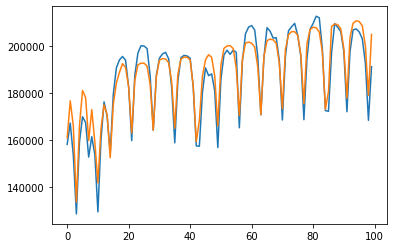

In [35]:
plt.plot(y_test)
plt.plot(pre)

In [38]:
np.mean(np.abs((y_test - pre)/y_test))*100

2.429385277385241

### Model 1 (lmbda_mu)

In [85]:
hyp = {
    'kernel' : "rbf",
    "C": 4.228517846555483, 
    "epsilon": 7.20604168948716, 
    "gamma": 0.0010113231069171437, 
    "lmbda": 1.5186395374328805, 
    "mu": 0.7423118951773942}
cvs2 = SVR_general_cvxopt(**hyp).fit(X, y)

In [86]:
pre2 = cvs2.predict(X_test)

In [87]:
pre2 = scaler1.inverse_transform(pre2.reshape(-1, 1))

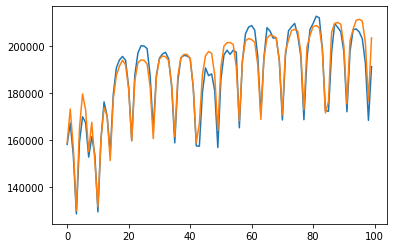

In [88]:
plt.plot(y_test)
plt.plot(pre2)

In [89]:
np.mean(np.abs((y_test - pre2)/y_test))*100

1.8416601559050254

# Prediccion a 7 dias

In [62]:
import cufflinks as cf
cf.go_offline()

In [63]:
y1 =pd.read_excel(r'Data//Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]
X1 = pd.read_csv("X.csv")

X = X1.drop(["fecha"], axis = 1).to_numpy(); y = y1.to_numpy()

X, X_test, y, y_test = train_test_split(X, y, test_size = 300, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X); X = scaler.transform(X)
X_test = scaler.transform(X_test)

scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1.transform(y).reshape(-1)

In [64]:
    hyperparameters = {
        'kernel' : "rbf",
        'C' : 1.5622596668986724, 
        'epsilon' : 0.01, 
        'mu' : 0.8894683237212756,
        'lmbda' : 0.7147423174236999,
        'gamma' : 0.009632563464115184, 
    }
    
model = SVR_general_cvxopt(**hyperparameters).fit(X, y)

In [65]:
predict = model.predict(X_test)

In [66]:
pred = scaler1.inverse_transform(predict.reshape(-1, 1))

In [67]:
# 2.4610961642466016
np.mean(np.abs((y_test - pred)/y_test))*100

2.4610882886101795

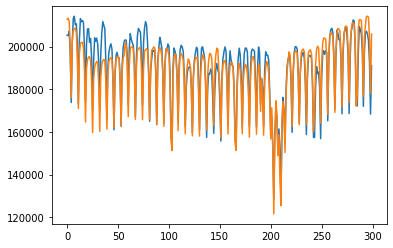

In [68]:
plt.plot(y_test)
plt.plot(pred)

In [69]:
plotting = pd.DataFrame(y1.tail(300))
plotting["predict"] = pred

In [70]:
plotting.iplot()

# Econn

In [76]:
from sklearn.metrics.pairwise import pairwise_kernels, linear_kernel, rbf_kernel

In [27]:
class Coca():
    def __init__(self, kernel = "linear", **rest):
        self.kernel = kernel
        self.rest = rest
        
    def create_kernel(self, X):
        kernel = self.kernel
        rest = self.rest
        
        def create(X, kernel):
            if kernel == "linear":
                K = pairwise_kernels(X, X, metric = "linear")
            else:
                K = pairwise_kernels(X, X, metric = kernel, **rest)
                
            return K
        
        def run():
            
            one = create(X, "linear")
            
            other = (kernel, rest.values())
            two = create(X, kernel)
            
            self.one = one; self.two = two
            return self
        
        return run()
        
    def ocation(self):
        return self.one, self.two

In [36]:
un, dos = Coca(kernel = "linear", gamma = 0.01).create_kernel(X).ocation()